# AI Project: COVID-19, Pneumonia, and Normal Chest X-ray Classification

## 1: Import Necessary Libraries

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')


## 2: Set Paths to Training and Testing Data

In [10]:
train_dir = 'Data/train'  # Path to the training data folder
test_dir = 'Data/test'    # Path to the test data folder

## 3: Create Image Data Generators for Augmentation and Preprocessing

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values to [0,1]
    rotation_range=20,        # Randomly rotate images
    zoom_range=0.2,           # Randomly zoom images
    shear_range=0.2,          # Randomly shear images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

## 4: Load Training and Testing Datasets from Directories

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,           # Process 32 images in a batch
    class_mode='categorical' # 3 categories (COVID-19, Pneumonia, Normal)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for consistent test evaluation
)

# Print the number of samples and class labels
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")
print(f"Class labels: {train_generator.class_indices}")


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Number of training samples: 5144
Number of test samples: 1288
Class labels: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


## 5: Display Sample Images

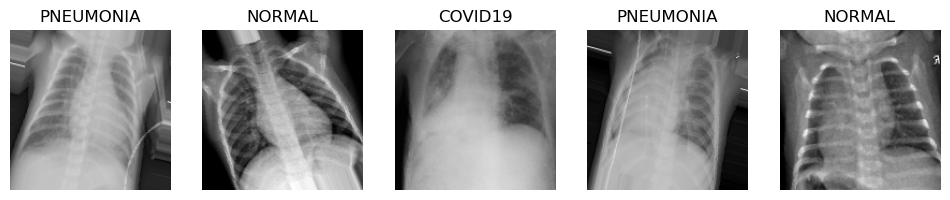

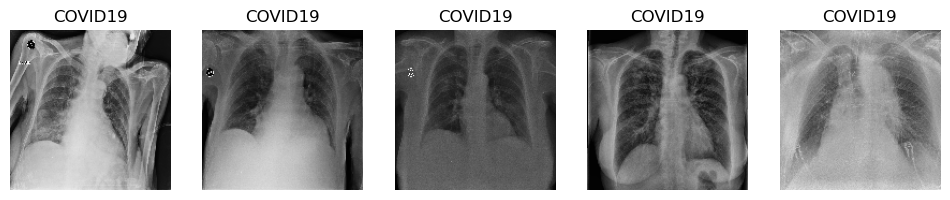

In [13]:
def display_sample_images(generator, num_images=5):
    # Get one batch of images and labels
    images, labels = next(generator)
    
    # Class labels
    class_labels = list(generator.class_indices.keys())
    
    # Plot sample images
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        # Get the image and its corresponding label
        img = images[i]
        label = np.argmax(labels[i])
        
        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_labels[label])
    
    plt.show()

# Display sample images from the training dataset
display_sample_images(train_generator)

# Optionally, display sample images from the test dataset
display_sample_images(test_generator)


## 6: Build Convolutional Neural Network (CNN) Model

In [14]:
# Define the Sequential model
model = Sequential()

# Adding Input Layer (using Input for defining input shape)
model.add(Input(shape=(150, 150, 3)))  # Input layer for RGB images with 150x150 resolution

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu'))  # No need to pass input_shape again
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer to reduce spatial size

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Now, you can continue adding more layers like Dense, Flatten, etc., if needed

## 7: Add Fully Connected Layers and Output Layer

In [15]:
model.add(Flatten())  # Flatten the 3D output to 1D for the fully connected layers
model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 neurons
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(3, activation='softmax'))  # Output layer with 3 neurons (one for each class)


## 8: Compile the Model

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 9: Set Up Model Checkpoints and Early Stopping

In [17]:
checkpoint = ModelCheckpoint('best_model1.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)


## 10: Train the Model


In [18]:
history = model.fit(
    train_generator,       # Training data
    epochs=25,             # Train for 25 epochs
    validation_data=test_generator,  # Validation data
    callbacks=[checkpoint, early_stopping]  # Use checkpoint and early stopping
)

Epoch 1/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7080 - loss: 0.7135 
Epoch 1: val_accuracy improved from -inf to 0.87112, saving model to best_model1.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 1904s 11s/step - accuracy: 0.7083 - loss: 0.7127 - val_accuracy: 0.8711 - val_loss: 0.3339
Epoch 2/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8211 - loss: 0.4281 
Epoch 2: val_accuracy improved from 0.87112 to 0.91227, saving model to best_model1.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 2186s 13s/step - accuracy: 0.8212 - loss: 0.4280 - val_accuracy: 0.9123 - val_loss: 0.2481
Epoch 3/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8567 - loss: 0.3729
Epoch 3: val_accuracy did not improve from 0.91227
161/161 ━━━━━━━━━━━━━━━━━━━━ 1782s 11s/step - accuracy: 0.8566 - loss: 0.3730 - val_accuracy: 0.8905 - val_loss: 0.2616
Epoch 4/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8598 - loss: 0.3454 
Epoch 4: val_accuracy improved from 0.91227 to 0.91460, saving mo

## 11: Evaluate the Model on the Test Dataset

In [19]:
test_loss, test_acc = model.evaluate(test_generator)  # Evaluate the model on test data
print(f"Test accuracy: {test_acc:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9441 - loss: 0.2386
Test accuracy: 0.95


## 12: Generate Predictions on the Test Dataset

In [20]:
predictions = model.predict(test_generator)  # Make predictions on the test set
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

41/41 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step


## 13: Get True Labels for the Test Data

In [21]:
true_classes = test_generator.classes  # Get the true labels for the test data

## 14: Generate Classification Report and Confusion Matrix

In [22]:
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))  # Display classification metrics

conf_matrix = confusion_matrix(true_classes, predicted_classes)  # Confusion matrix
print("Confusion Matrix:")  # Display the confusion matrix
print(conf_matrix)

              precision    recall  f1-score   support

     COVID19       0.97      0.95      0.96       116
      NORMAL       0.90      0.90      0.90       317
   PNEUMONIA       0.96      0.96      0.96       855

    accuracy                           0.95      1288
   macro avg       0.94      0.94      0.94      1288
weighted avg       0.95      0.95      0.95      1288

Confusion Matrix:
[[110   0   6]
 [  2 286  29]
 [  1  31 823]]


## 15: Plot Training and Validation Accuracy/Loss Over Epochs

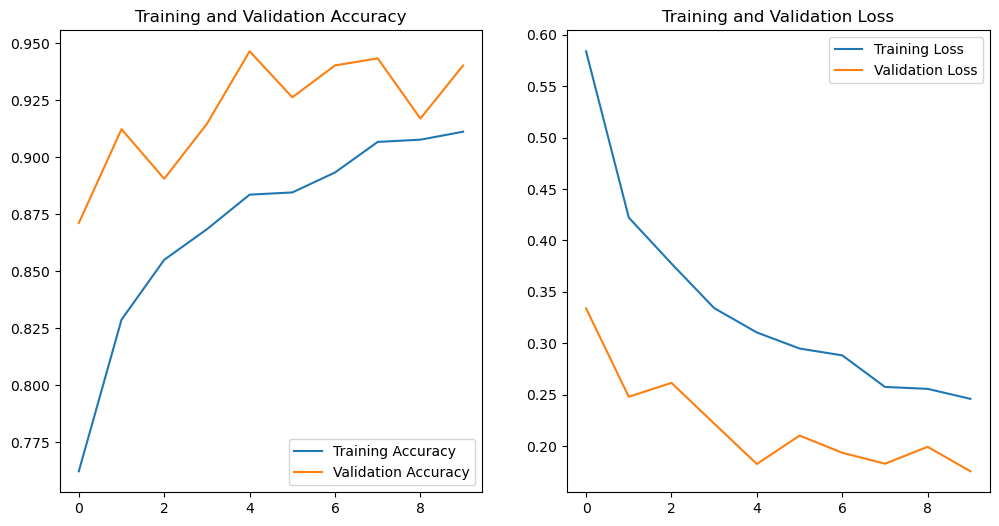

In [27]:
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

epochs_range = range(len(acc))  # Get the number of epochs

plt.figure(figsize=(12, 6))  # Set figure size

# Accuracy Plot
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Set legend location
plt.title('Training and Validation Accuracy')  # Set title for the plot

# Loss Plot
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Set legend location
plt.title('Training and Validation Loss')  # Set title for the plot
plt.show()  # Show the plots

## 16: Visualize predictions on individual test images


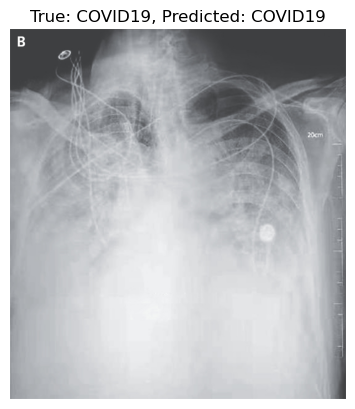

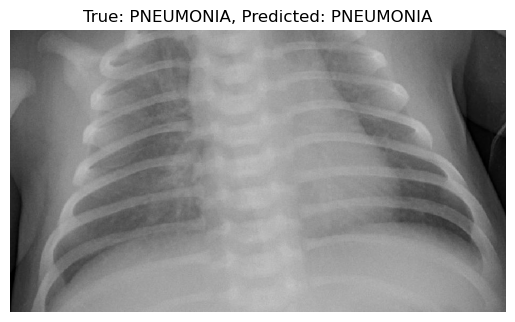

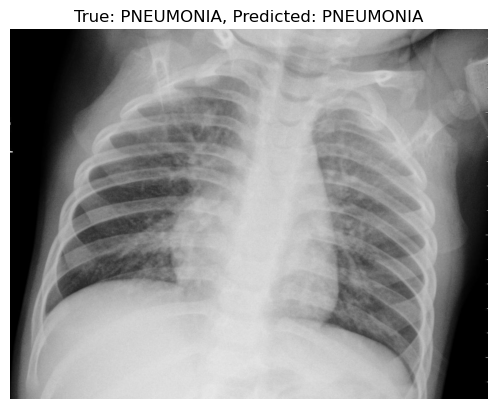

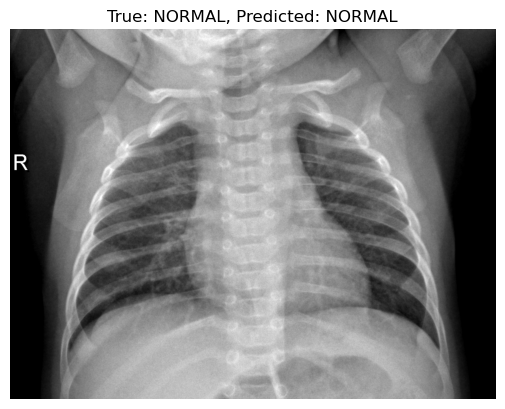

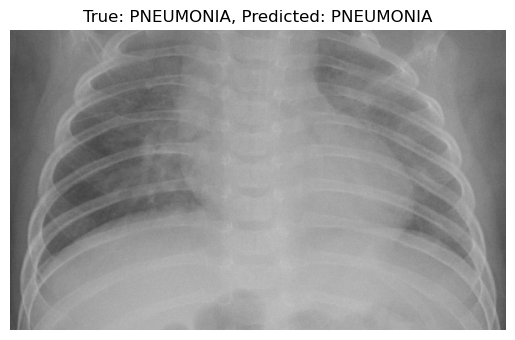

In [26]:
# List of specific indices to display
indices_to_display = [80, 800, 1000, 300, 600]

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

for i in indices_to_display:
    # Get the image path and the corresponding true label
    img_path = test_generator.filepaths[i]
    true_label = true_classes[i]
    
    # Load and preprocess the image
    img = plt.imread(img_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    
    # Get the predicted class for the image
    predicted_label = predicted_classes[i]
    
    # Set the title with the true and predicted class names
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    
    # Show the plot
    plt.show()
